
================ CABC: KHỞI TẠO ================
  X0 = [1.27601539 2.19526201], f(X0) = 3.1143
  X1 = [1.34749099 2.01700004], f(X1) = 3.1210
  X2 = [1.498844   1.50461867], f(X2) = 3.4942
  → Global best ban đầu: [1.27601539 2.19526201] , f = 3.1143117496563457
Iteration   1: global best f(x) = 3.087818, gbest = [1.22291391 2.19526201]
Iteration   2: global best f(x) = 3.031619, gbest = [1.15740035 1.91726868]
Iteration   3: global best f(x) = 3.016018, gbest = [1.09577982 1.91726868]
Iteration   4: global best f(x) = 3.016018, gbest = [1.09577982 1.91726868]
Iteration   5: global best f(x) = 3.010382, gbest = [1.05947455 1.91726868]
Iteration   6: global best f(x) = 3.006921, gbest = [0.99124843 1.91726868]
Iteration   7: global best f(x) = 3.006423, gbest = [0.99124843 1.92033383]
Iteration   8: global best f(x) = 3.006423, gbest = [0.99124843 1.92033383]
Iteration   9: global best f(x) = 3.006423, gbest = [0.99124843 1.92033383]
Iteration  10: global best f(x) = 3.006423, gbest =

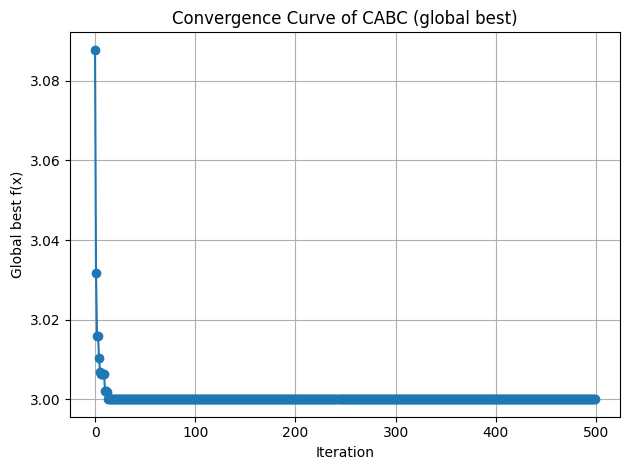

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ============================
#  THUẬT TOÁN CABC (có global_best)
# ============================
start = time.time()

N = 6
D = 2
SN = N // 2
LIMIT = (N * D) // 2
MAX_ITER = 500   # m đang để 500, giữ nguyên; nếu muốn so công bằng thì cho = 50

bounds = np.array([
    [0.5, 1.5],
    [1.5, 2.5]
])

# Tham số logistic map
mu = 4
z = np.random.rand()   # z0 ban đầu

def chaotic():
    """Sinh số hỗn loạn trong (0,1) theo logistic map."""
    global z
    z = mu * z * (1 - z)
    return z

# ========== KHỞI TẠO HỖN LOẠN ==========
food_sources = np.zeros((SN, D))
for i in range(SN):
    for j in range(D):
        c = chaotic()
        food_sources[i, j] = bounds[j][0] + c * (bounds[j][1] - bounds[j][0])

trial = np.zeros(SN, dtype=int)

# ========== HÀM MỤC TIÊU & FITNESS ==========
def objective(x):
    return (x[0] - 1)**2 + (x[1] - 2)**2 + 3

def fitness_func(f):
    return 1/(1+f)   # f luôn >= 3 trong bài toán này


# ========== SINH NGHIỆM MỚI CABC ==========
def generate_new_solution_cabc(i):
    k = np.random.randint(D)
    j = np.random.choice([a for a in range(SN) if a != i])

    z_loc = chaotic()
    # map về [-1,1], rồi giảm biên độ (0.7)
    phi = (2*z_loc - 1) * 0.7

    v = food_sources[i].copy()
    v[k] = v[k] + phi * (v[k] - food_sources[j][k])

    return np.clip(v, bounds[:, 0], bounds[:, 1])


# ========== KHỞI TẠO FITNESS + GLOBAL BEST ==========
fitness = np.array([fitness_func(objective(x)) for x in food_sources])

best_idx = np.argmax(fitness)
global_best_x = food_sources[best_idx].copy()
global_best_f = objective(global_best_x)

history_cabc = []

print("\n================ CABC: KHỞI TẠO ================")
for i, fs in enumerate(food_sources):
    print(f"  X{i} = {fs}, f(X{i}) = {objective(fs):.4f}")
print("  → Global best ban đầu:", global_best_x, ", f =", global_best_f)


# ========== VÒNG LẶP CABC ==========
for iteration in range(1, MAX_ITER + 1):

    # --- Ong thợ ---
    for i in range(SN):
        v = generate_new_solution_cabc(i)

        f_new = objective(v)
        f_old = objective(food_sources[i])
        fit_new = fitness_func(f_new)
        fit_old = fitness_func(f_old)

        if fit_new > fit_old:
            food_sources[i] = v
            fitness[i] = fit_new
            trial[i] = 0
        else:
            trial[i] += 1

    # --- Ong quan sát ---
    prob = fitness / np.sum(fitness)

    for _ in range(SN):
        i = np.random.choice(range(SN), p=prob)
        v = generate_new_solution_cabc(i)

        f_new = objective(v)
        f_old = objective(food_sources[i])
        fit_new = fitness_func(f_new)
        fit_old = fitness_func(f_old)

        if fit_new > fit_old:
            food_sources[i] = v
            fitness[i] = fit_new
            trial[i] = 0
        else:
            trial[i] += 1

    # --- Ong do thám ---
    for i in range(SN):
        if trial[i] > LIMIT:
            for j in range(D):
                c = chaotic()
                food_sources[i][j] = bounds[j][0] + c * (bounds[j][1] - bounds[j][0])
            trial[i] = 0
            fitness[i] = fitness_func(objective(food_sources[i]))

    # --- CẬP NHẬT GLOBAL BEST ---
    best_idx = np.argmax(fitness)
    current_best_x = food_sources[best_idx].copy()
    current_best_f = objective(current_best_x)

    if current_best_f < global_best_f:
        global_best_f = current_best_f
        global_best_x = current_best_x.copy()

    history_cabc.append(global_best_f)
    print(f"Iteration {iteration:3d}: global best f(x) = {global_best_f:.6f}, gbest = {global_best_x}")

end = time.time()

print("\n=== KẾT QUẢ CUỐI CÙNG (CABC) ===")
print("Global best ≈", global_best_x)
print("f(Global best) ≈", global_best_f)
print(f"Thời gian chạy CABC: {end - start:.6f} giây")

# ========== VẼ ĐỒ THỊ HỘI TỤ ==========
plt.plot(history_cabc, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Global best f(x)")
plt.title("Convergence Curve of CABC (global best)")
plt.grid(True)
plt.tight_layout()
plt.show()
